En este proyecto realizaremos una red neuronal con la intencion de a traves de imagenes obtener predicciones de que numeros son a los que perteneces.

Empezaremos creando de una base de datos 60,000 datos de entrenamiento y prueba, para posteriormente hacer obtener el modelo y ver que tambien predice y ver si es necesario mejoralo.

Para terminar obtneiendo nuesto modelo en .h5 para hacerlo funcionar en tiempo real.

In [192]:

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
print("Shape of training images:", train_images.shape)
print("Shape of training labels:", train_labels.shape)
print("Shape of testing images:", test_images.shape)
print("Shape of testing labels:", test_labels.shape)

train_images=train_images.astype('float32')/255.0
test_images=test_images.astype('float32')/255.0

Shape of training images: (60000, 28, 28)
Shape of training labels: (60000,)
Shape of testing images: (10000, 28, 28)
Shape of testing labels: (10000,)


Uno de los primeros cambios que realizamremos sera normalizar los parametros conviriendo los datos a datos flotates y dividiendolos entre la cantidad de pixeles que tendremos para normalizarlo.

Ahora revisaremos la proporcion de las clases, tanto para train como test.

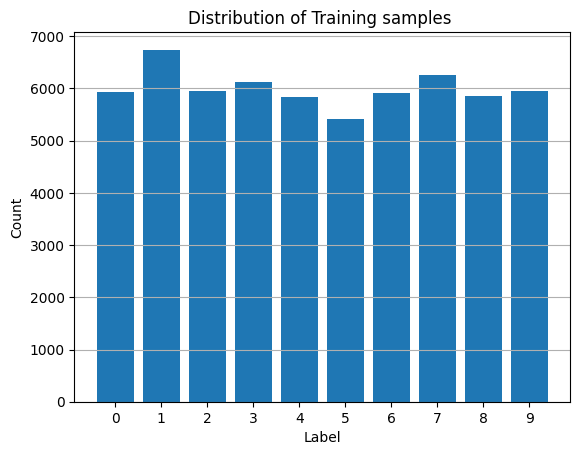

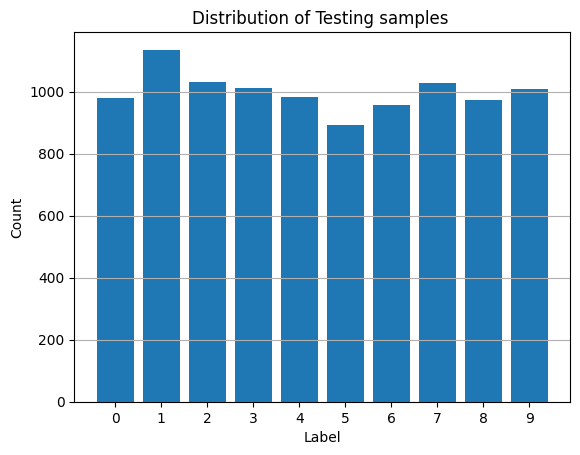

In [193]:

unique, counts = np.unique(train_labels, return_counts=True)
plt.bar(unique, counts, tick_label=unique)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Training samples ')
plt.grid(axis='y')
plt.show()



unique, counts = np.unique(test_labels, return_counts=True)
plt.bar(unique, counts, tick_label=unique)
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Testing samples ')
plt.grid(axis='y')
plt.show()


Podemos ver que hay numeros que predice mejor que otros, pero sin tanta desviacion, asi que seguiremos.

Ahora mostraremos los numeros generados aleatoriamente, para tener una idea de que es con lo que podemos trabajar. A su vez con tenserflow y keras crearemos un modelo de redes neuronales para que utilizaremos para predecir.

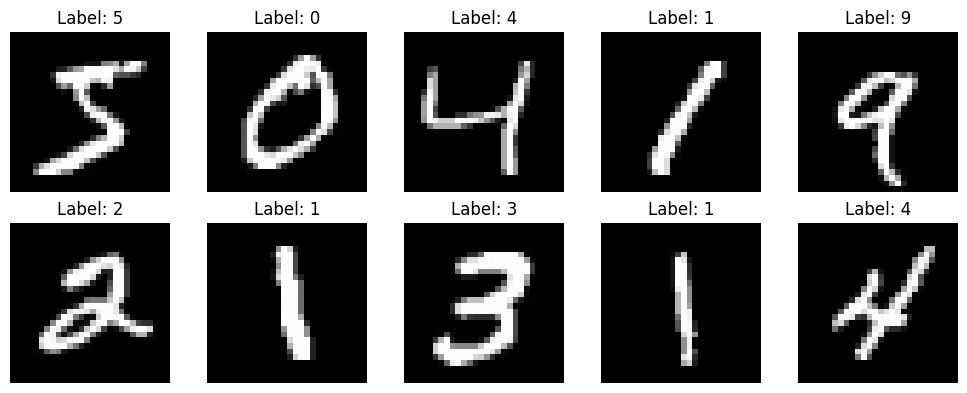

In [194]:
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_images[i], cmap='gray')
    plt.title(f"Label: {train_labels[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

In [195]:
print("Min pixel value in training set:", np.min(train_images))
print("Max pixel value in training set:", np.max(train_images))

Min pixel value in training set: 0.0
Max pixel value in training set: 1.0


In [196]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout

model = Sequential()
model.add(Flatten(input_shape=(28, 28)))

/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [197]:

model.add(Dense(256, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.40))   # regulariza la capa grande

model.add(Dense(128, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.30))   # un poco menos de dropout

model.add(Dense(64,  activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.20))   # leve para no “ahogar” la capacidad

model.add(Dense(10, activation='softmax'))


El segundo cambio que realizaremos sera agregar un dropout de regularizacion para que nuestro modelo sea mas limpio y pueda trabajar con datos que sirvan sin crear capas inecesarias. Con 40% al incio mientras decae para ir mejorando la generalización del modelo.
A su vez con kernel_initializer='he_normal nos ayuda a no iniciar desde 0 y perder redes que si eran importantes.

Ahora haremos que se vuelvan a entrenar los datos, mejorando el accuracy, para asi trabajar de mejor manera con esta red neuronal.

In [198]:
from tensorflow.keras.optimizers import Adam
opt = Adam(learning_rate=0.001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_8 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,762 (948.29 KB)

 Trainable params: 242,762 (948.29 KB)

 Non-trainable params: 0 (0.00 B)

In [199]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

In [200]:
history=model.fit(train_images, train_labels, epochs=50, validation_split=0.4,
                  batch_size=32, callbacks=[early_stopping])

Epoch 1/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - accuracy: 0.7184 - loss: 0.8474 - val_accuracy: 0.9431 - val_loss: 0.1841
Epoch 2/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9304 - loss: 0.2443 - val_accuracy: 0.9587 - val_loss: 0.1404
Epoch 3/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9440 - loss: 0.1965 - val_accuracy: 0.9626 - val_loss: 0.1295
Epoch 4/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.9519 - loss: 0.1678 - val_accuracy: 0.9664 - val_loss: 0.1199
Epoch 5/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9584 - loss: 0.1390 - val_accuracy: 0.9690 - val_loss: 0.1110
Epoch 6/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - accuracy: 0.9634 - loss: 0.1220 - val_accuracy: 0.9702 - val_loss: 0.1092
Epoch 7/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - accuracy: 0.9659 - loss: 0.1197 - val_accuracy: 0.9689 - val_loss: 0.1134
Epoch 8/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - accuracy: 0.9672 - loss: 0.11

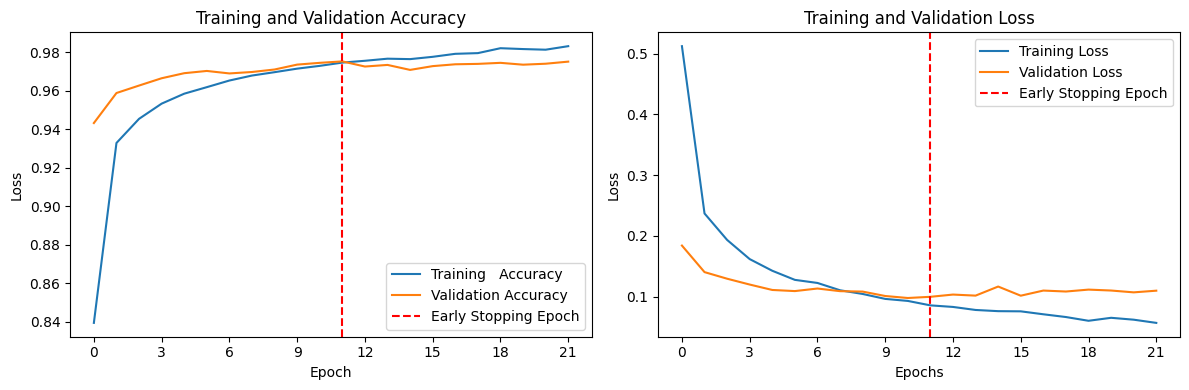

In [201]:
from matplotlib.ticker import MaxNLocator
stopped_epoch = early_stopping.stopped_epoch
best_epoch=stopped_epoch-early_stopping.patience
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training   Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axvline(x=best_epoch, color='r', linestyle='--', label='Early Stopping Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Accuracy')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axvline(x=best_epoch, color='r', linestyle='--', label='Early Stopping Epoch')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True)) # Ensure integer values on x-axis
plt.legend()
plt.tight_layout()
plt.show()

Podemos obseervar con estas graficas que el modelo deja de mejorar significativcamente despues de 10 iteraciones, por lo que hacer al rededor de 50 fue incesario, lo cual podriamos ajustar, pero esto nos dice que para entrenar y validar lo que hemos hecho hasta ahora esta dando frutos, mejorando significativamente para despues.

Ahora haremos que se pueda tomar una foto desde nuestra laptop o celular y que se guarde para analizarla mas a profundidad y que prediga algo el modelo, que fue ensellado en el taller.

In [202]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
        async function takePhoto(quality) {
            const div = document.createElement('div');
            const capture = document.createElement('button');
            capture.textContent = 'Capture';
            div.appendChild(capture);

            const video = document.createElement('video');
            video.style.display = 'block';
            const stream = await navigator.mediaDevices.getUserMedia({video: true});

            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            // Wait for Capture to be clicked.
            await new Promise((resolve) => capture.onclick = resolve);

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);
            stream.getVideoTracks()[0].stop();
            div.remove();
            return canvas.toDataURL('image/jpeg', quality);
        }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

import cv2
print(cv2.__version__)

4.12.0


In [203]:
# Capture an image
take_photo()

<IPython.core.display.Javascript object>

'photo.jpg'

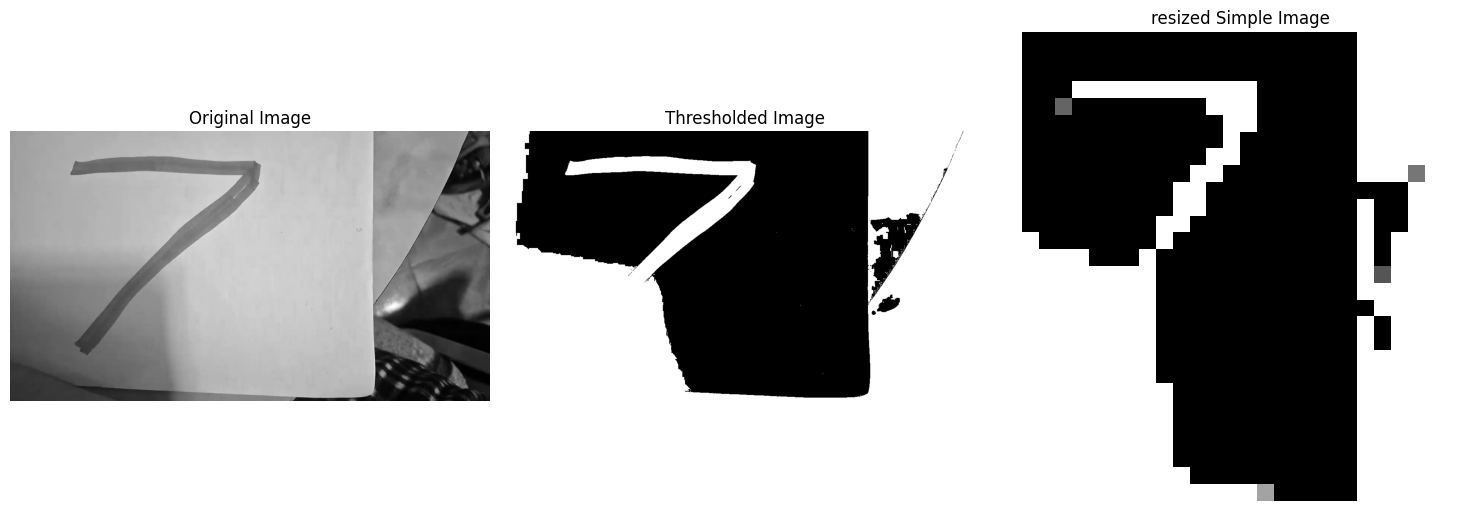

In [204]:
image = cv2.imread('photo.jpg', cv2.IMREAD_GRAYSCALE)
# Thresholding
_, thresh = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY_INV)
# Resize the image to 28x28 pixels
resizedSimple = cv2.resize(thresh, (28, 28))

# Display the images side by side
fig, axes = plt.subplots(1, 3, figsize=(15, 5))# Original Image
axes[0].imshow(image, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

axes[1].imshow(thresh, cmap='gray')
axes[1].set_title('Thresholded Image')
axes[1].axis('off')

axes[2].imshow(resizedSimple, cmap='gray')
axes[2].set_title('resized Simple Image')
axes[2].axis('off')
plt.tight_layout()
plt.show()

In [205]:
# Reshape the image for model compatibility (batch size, height, width, channels)
input_image = resizedSimple.reshape(1, 28, 28, 1) *255.0
# Use the mode's predict method
prediction = model.predict(input_image)
predicted_label = np.argmax(prediction)
# Display the result
print("Numero Probable")
for i, prob in enumerate(prediction[0]):
    print(f"  {i}   |   {prob:.5f}")
print(f"El numero predicho es: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
Numero Probable
  0   |   0.00000
  1   |   0.00000
  2   |   0.00000
  3   |   0.00000
  4   |   0.00000
  5   |   1.00000
  6   |   0.00000
  7   |   0.00000
  8   |   0.00000
  9   |   0.00000
El numero predicho es: 5


Aunque nuestros resultado no fue el predicho ya que era un 7 fue algo que tal vez por las sombras no pudo predecir de manera correcta.

Ahora cargaremos una base de datos de numeros realizado por mi y cargados a Google Drive donde se encuentras 5 imagenes por cada digito y prediciremos cual numero es, a su vez sacaremos a cuantos numeros predecimos de manera correcta en base al nommbre de la imagen.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


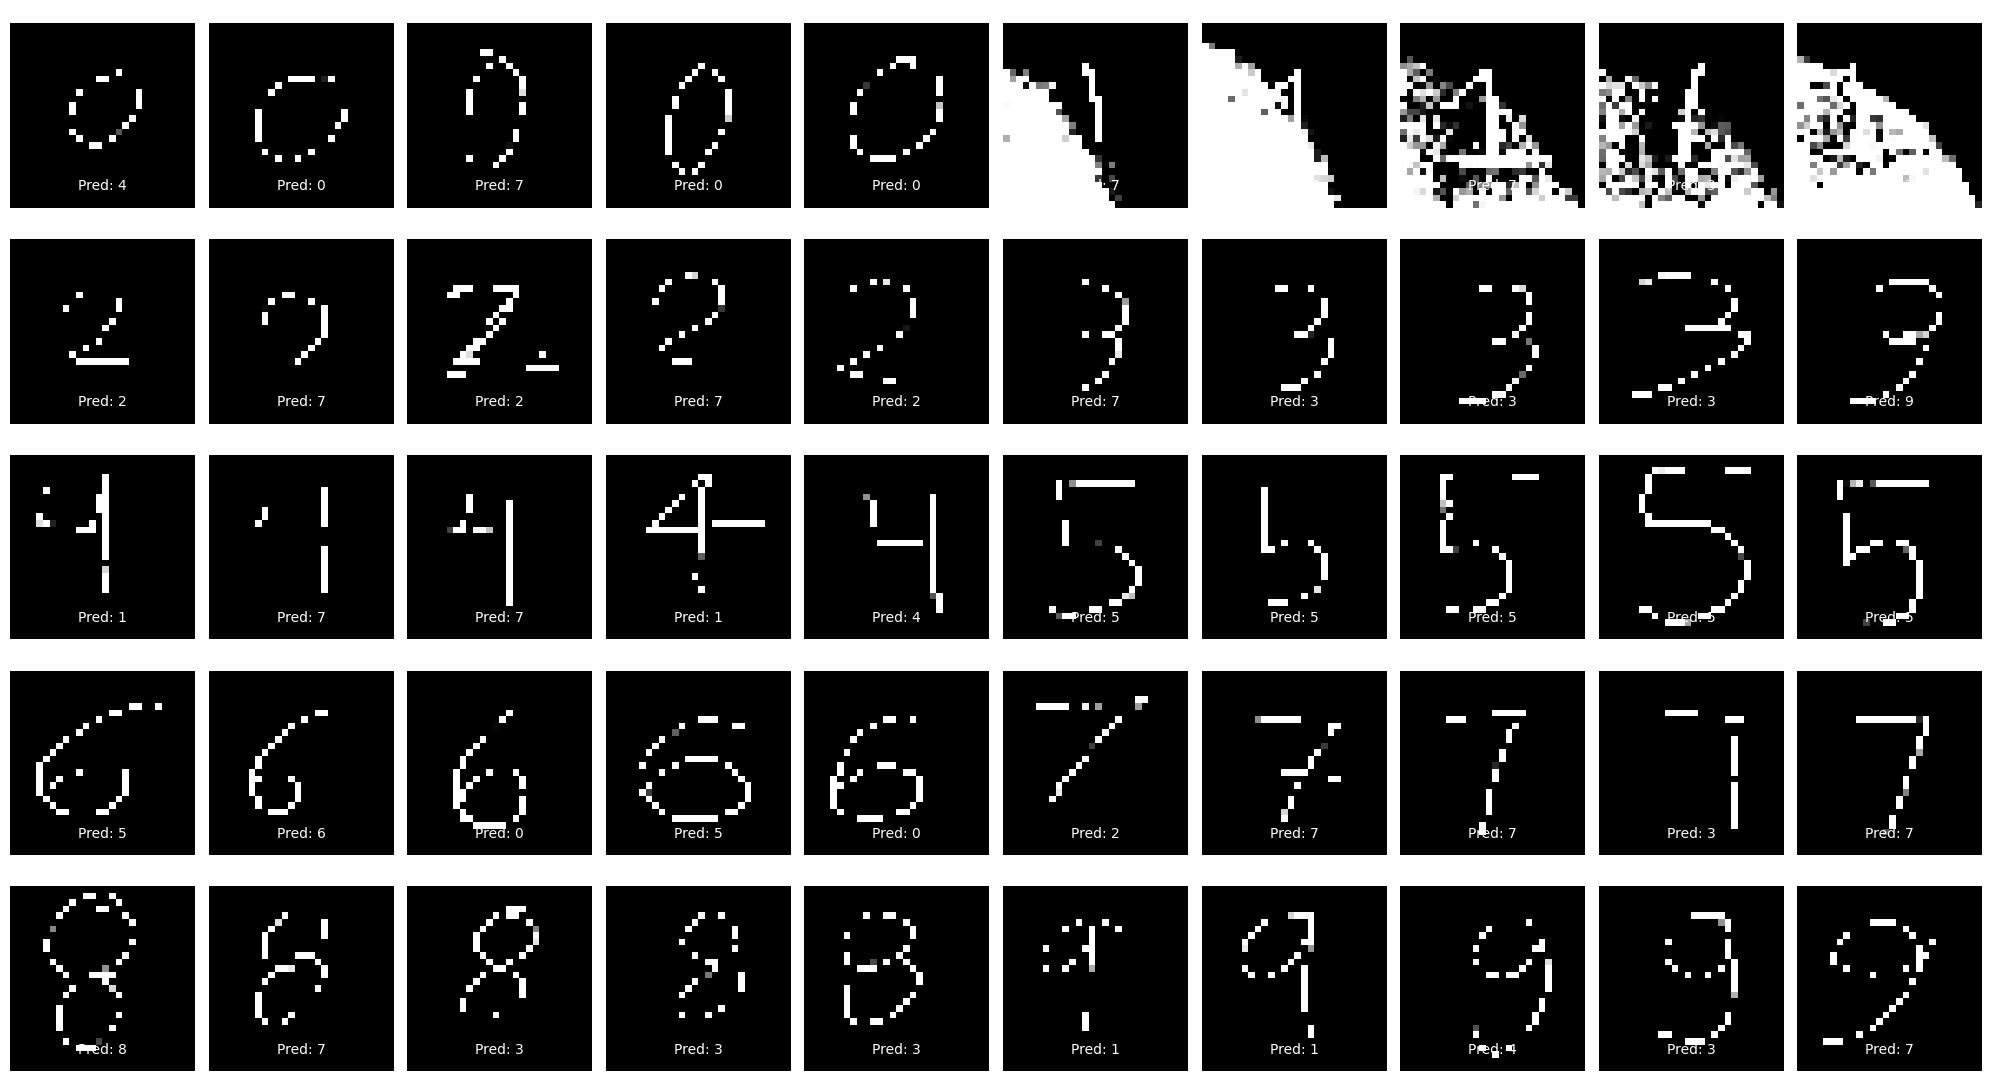

0,1.jpg                        -> Pred: 4
0,2.jpg                        -> Pred: 0
0,3.jpg                        -> Pred: 7
0,4.jpg                        -> Pred: 0
0,5.jpg                        -> Pred: 0
1,1.jpg                        -> Pred: 7
1,2.jpg                        -> Pred: 7
1,3.jpg                        -> Pred: 7
1,4.jpg                        -> Pred: 3
1,5.jpg                        -> Pred: 7
2,1.jpg                        -> Pred: 2
2,2.jpg                        -> Pred: 7
2,3.jpg                        -> Pred: 2
2,4 (1).jpg                    -> Pred: 7
2,5.jpg                        -> Pred: 2
3,1.jpg                        -> Pred: 7
3,2.jpg                        -> Pred: 3
3,3.jpg                        -> Pred: 3
3,4.jpg                        -> Pred: 3
3,5.jpg                        -> Pred: 9
4,1.jpg                        -> Pred: 1
4,2.jpg                        -> Pred: 7
4,3.jpg                        -> Pred: 7
4,4.jpg                        -> 

In [210]:
from google.colab import drive
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math
import re

drive.mount('/content/drive')
FOLDER = '/content/drive/MyDrive/Jupyter/Redes_Neuronales_Parcial_3/50numeros_del_0_a_9'


if not os.path.exists(FOLDER):
    print(f"Error: Carpeta no encontrada {FOLDER}")
else:
    image_files = [f for f in sorted(os.listdir(FOLDER)) if f.lower().endswith('.jpg')]

    resized_list = []
    name_list = []

    for i, filename in enumerate(image_files):
        photo_filename = os.path.join(FOLDER, filename)
        image = cv2.imread(photo_filename, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Error al cargar la imagen: {photo_filename}")
            continue

        _, thresh = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)
        resized = cv2.resize(thresh, (28, 28))
        resized_list.append(resized)
        name_list.append(filename)

    pred_list = []
    if 'model' in globals() and resized_list:
        for img28 in resized_list:
            inp = img28.reshape(1, 28, 28, 1).astype(np.float32)
            pred = model.predict(inp, verbose=0)[0]
            pred_list.append(int(np.argmax(pred)))
    else:
        if not 'model' in globals():
            print("Nota: No encontré la variable 'model' cargada en el entorno. "
                  "Carga tu modelo (.h5) antes de ejecutar esta celda para obtener predicciones.")


    if resized_list:
        COLS = 10
        N = len(resized_list)
        ROWS = math.ceil(N / COLS)
        fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS*2, ROWS*2.2))
        axes = np.atleast_1d(axes).ravel()

        for idx in range(ROWS*COLS):
            ax = axes[idx]
            if idx < N:
                ax.set_facecolor('black')
                ax.imshow(resized_list[idx], cmap='gray', vmin=0, vmax=255)
                ax.set_title(name_list[idx], fontsize=8, color='white', pad=4)
                ax.axis('off')

                if pred_list:
                    ax.text(0.5, 0.08, f"Pred: {pred_list[idx]}", color='white',
                            fontsize=10, ha='center', va='bottom', transform=ax.transAxes)
            else:
                ax.axis('off')

        plt.tight_layout(pad=1.0)
        plt.show()

        if pred_list:
            for fname, p in zip(name_list, pred_list):
                print(f"{fname:<30} -> Pred: {p}")

        if pred_list:
            gts = []
            for fname in name_list:
                m = re.search(r'(\d)', fname)
                gts.append(int(m.group(1)) if m else None)

            pairs = [(p, g) for p, g in zip(pred_list, gts) if g is not None]
            if pairs:
                correct = sum(int(p == g) for p, g in pairs)
                acc = 100.0 * correct / len(pairs)
                print(f"\nAccuracy: {acc:.2f}%  ({correct}/{len(pairs)})")
            else:
                print("\nNo se pudo calcular accuracy: no encontré dígitos en los nombres de archivo.")
    else:
        print("No hay imágenes válidas para mostrar.")



Podemos ver que no es muy bueno pero aun asi para las pocas modificaciones que le hemos hecho y que se tarda un aproximado de 5 minutos en terminar de correr el programa esta muy bien.

Como ultimo agregaremos algunas metricas, como un filtro Gaussiano, esto para suavizar la imagen para que sea mas sencillo de interpretar a la hora de hacer identificar la escala de grises.
Tambien aplicaremos CLAHE para mejorar el contrastre con la imagen y ver más definido aunque haya sombras o luz dispareja.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


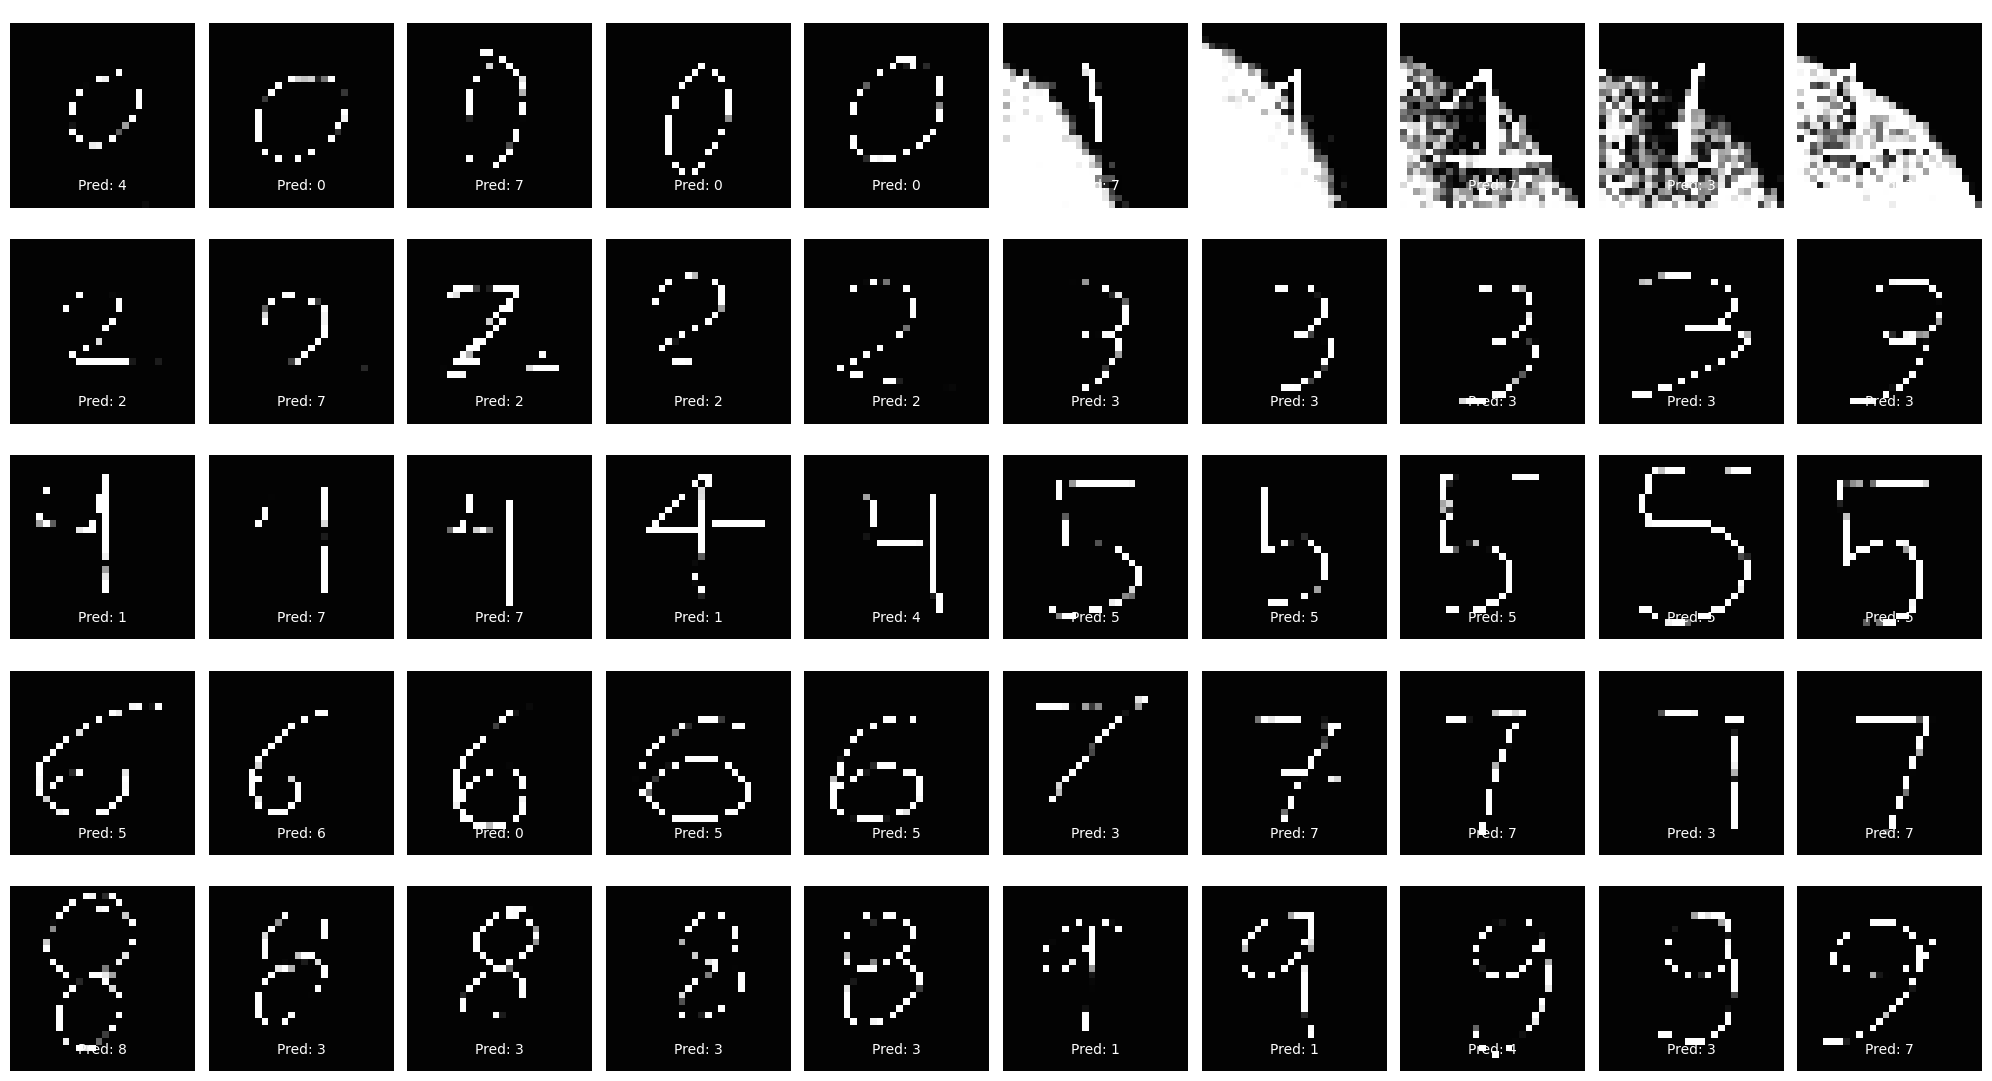

0,1.jpg                        -> Pred: 4
0,2.jpg                        -> Pred: 0
0,3.jpg                        -> Pred: 7
0,4.jpg                        -> Pred: 0
0,5.jpg                        -> Pred: 0
1,1.jpg                        -> Pred: 7
1,2.jpg                        -> Pred: 7
1,3.jpg                        -> Pred: 7
1,4.jpg                        -> Pred: 3
1,5.jpg                        -> Pred: 3
2,1.jpg                        -> Pred: 2
2,2.jpg                        -> Pred: 7
2,3.jpg                        -> Pred: 2
2,4 (1).jpg                    -> Pred: 2
2,5.jpg                        -> Pred: 2
3,1.jpg                        -> Pred: 3
3,2.jpg                        -> Pred: 3
3,3.jpg                        -> Pred: 3
3,4.jpg                        -> Pred: 3
3,5.jpg                        -> Pred: 3
4,1.jpg                        -> Pred: 1
4,2.jpg                        -> Pred: 7
4,3.jpg                        -> Pred: 7
4,4.jpg                        -> 

In [213]:
import math
import re

drive.mount('/content/drive')
FOLDER = '/content/drive/MyDrive/Jupyter/Redes_Neuronales_Parcial_3/50numeros_del_0_a_9'


if not os.path.exists(FOLDER):
    print(f"Error: Carpeta no encontrada {FOLDER}")
else:
    image_files = [f for f in sorted(os.listdir(FOLDER)) if f.lower().endswith('.jpg')]

    resized_list = []
    name_list = []

    for i, filename in enumerate(image_files):
        photo_filename = os.path.join(FOLDER, filename)
        image = cv2.imread(photo_filename, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"Error al cargar la imagen: {photo_filename}")
            continue

        _, thresh = cv2.threshold(image, 128, 255, cv2.THRESH_BINARY_INV)
        # Aplicar un filtro Gaussiano para suavizar la imagen
        blurred = cv2.GaussianBlur(thresh, (5, 5), 0)
        # Aplicar CLAHE para mejorar el contraste de la imagen
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        contrast_enhanced = clahe.apply(blurred)

        resized2 = cv2.resize(contrast_enhanced, (28, 28))
        name_list.append(filename)

        resized_list.append(resized2)

    pred_list = []
    if 'model' in globals() and resized_list:
        for img28 in resized_list:
            inp = img28.reshape(1, 28, 28, 1).astype(np.float32)
            pred = model.predict(inp, verbose=0)[0]
            pred_list.append(int(np.argmax(pred)))
    else:
        if not 'model' in globals():
            print("Nota: No encontré la variable 'model' cargada en el entorno. "
                  "Carga tu modelo (.h5) antes de ejecutar esta celda para obtener predicciones.")

    acc_txt = ""
    if pred_list:
        gts = []
        for fname in name_list:
            m = re.search(r'(\d)', fname)
            gts.append(int(m.group(1)) if m else None)
        pairs = [(p, g) for p, g in zip(pred_list, gts) if g is not None]
        if pairs:
            correct = sum(int(p == g) for p, g in pairs)
            acc = 100.0 * correct / len(pairs)
            acc_txt = f" | Accuracy: {acc:.2f}% ({correct}/{len(pairs)})"

    if resized_list:
        COLS = 10
        N = len(resized_list)
        ROWS = math.ceil(N / COLS)
        fig, axes = plt.subplots(ROWS, COLS, figsize=(COLS*2, ROWS*2.2))
        axes = np.atleast_1d(axes).ravel()

        for idx in range(ROWS*COLS):
            ax = axes[idx]
            if idx < N:
                ax.set_facecolor('black')
                ax.imshow(resized_list[idx], cmap='gray', vmin=0, vmax=255)
                ax.set_title(name_list[idx], fontsize=8, color='white', pad=4)
                ax.axis('off')
                if pred_list:
                    ax.text(0.5, 0.08, f"Pred: {pred_list[idx]}", color='white',
                            fontsize=10, ha='center', va='bottom', transform=ax.transAxes)
            else:
                ax.axis('off')

        plt.tight_layout(pad=1.0)
        plt.show()

        if pred_list:
            for fname, p in zip(name_list, pred_list):
                print(f"{fname:<30} -> Pred: {p}")
            if acc_txt:
                print(acc_txt)
    else:
        print("No hay imágenes válidas para mostrar.")


Podemos ver que mejora un 6% siendo que es una mejora aunque no superamos el 50% es una mejora, viendo que si siguieramos metiendole mejoras podriamos  llegar a hacer que con solamente redes neuronales densas obtener un accuracy muy cercano a 100.

Ahora obtenremos el .h5 para hacer un modelo en tiempo real.

In [208]:
model.save("Deteccion_numeros.h5")